### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

import sqlite3 as sqlite
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [3]:
# 10770229 rows × 28 columns
flights = pd.read_csv(data_path + 'flights_cleaned.csv', header = 0)
flights.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
# Flight delays with outliers
flights_outlier = pd.read_csv(data_path + 'flight_delay_with_outliers.csv', header = 0)
flights_outlier.drop('Unnamed: 0', axis =1, inplace = True)
# Seperating date to (YEAR, MONTH, DAY)
flights_outlier['fl_date'] = pd.to_datetime(flights_outlier['fl_date'])
flights_outlier['year'] = flights_outlier['fl_date'].dt.year
flights_outlier['month'] = flights_outlier['fl_date'].dt.month
flights_outlier['date'] = flights_outlier['fl_date'].dt.day
# Dropping the old date column
flights_outlier.drop('fl_date', axis = 1, inplace = True)

In [5]:
# 15610974 rows × 5 columns
# 15610958
flights_no_extreme_outlier = copy.deepcopy(flights_outlier[(flights_outlier['dep_delay']<1500) | (flights_outlier['arr_delay']<1500)])
flights_no_extreme_outlier.dropna(inplace = True)
flights_no_extreme_outlier = flights_no_extreme_outlier[-600<flights_no_extreme_outlier['dep_delay']]
flights_no_extreme_outlier.drop(48313, axis = 0, inplace = True)
to_drop = list(flights_no_extreme_outlier[(flights_no_extreme_outlier['dep_delay']>150)&(flights_no_extreme_outlier['arr_delay']<=0)].index)
flights_no_extreme_outlier.drop(to_drop, axis = 0, inplace = True)
flights_no_extreme_outlier

,dep_delay,arr_delay,year,month,date
0,-2.0,-12.0,2019,3,25
1,-5.0,-19.0,2019,3,25
2,1.0,-10.0,2019,3,25
3,99.0,94.0,2019,3,25
4,166.0,152.0,2019,3,25
...,...,...,...,...,...
15927480,16.0,-3.0,2019,3,25
15927481,88.0,99.0,2019,3,25
15927482,-5.0,-18.0,2019,3,25
15927483,-2.0,-11.0,2019,3,25


<AxesSubplot:xlabel='dep_delay', ylabel='arr_delay'>

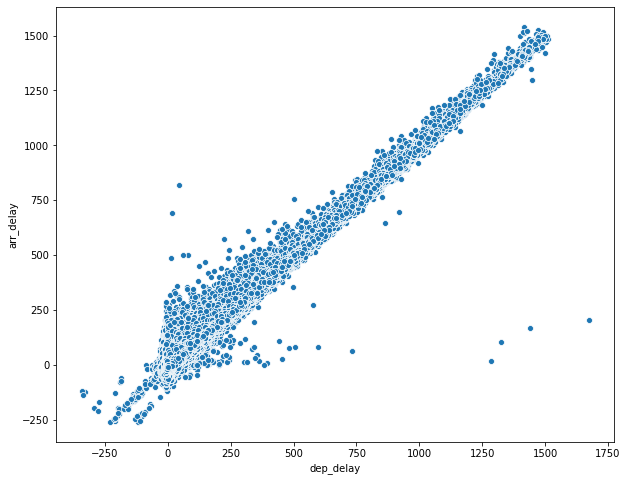

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(flights_no_extreme_outlier['dep_delay'],flights_no_extreme_outlier['arr_delay'])
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_5_arr~dep.png')

In [71]:
# four groups: both late, both early, dep late and arr early, dep early and arr late
# first late/early refers to dep, and the second refer to arr
# 3900799
flight_late_late = flights_no_extreme_outlier[(0<flights_no_extreme_outlier['dep_delay'])&(0<flights_no_extreme_outlier['arr_delay'])]
# 1573433
flight_early_late = flights_no_extreme_outlier[(flights_no_extreme_outlier['dep_delay']<=0)&(0<flights_no_extreme_outlier['arr_delay'])]
# 1414653
flight_late_early = flights_no_extreme_outlier[(0<flights_no_extreme_outlier['dep_delay'])&(flights_no_extreme_outlier['arr_delay']<=0)]
# 8722073
flight_early_early = flights_no_extreme_outlier[(flights_no_extreme_outlier['dep_delay']<=0)&(flights_no_extreme_outlier['arr_delay']<=0)]

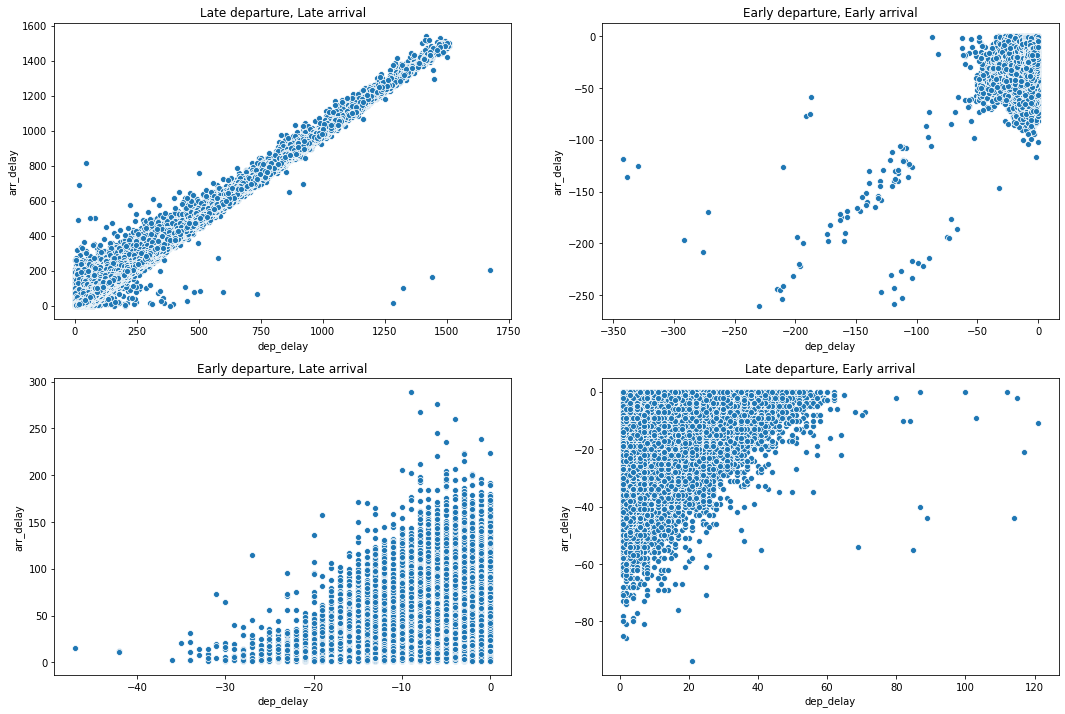

In [73]:
fig, ax = plt.subplots(2,2,figsize=(18,12))
sns.scatterplot(flight_late_late['dep_delay'],flight_late_late['arr_delay'], ax = ax[0][0])
sns.scatterplot(flight_early_early['dep_delay'],flight_early_early['arr_delay'], ax = ax[0][1])
sns.scatterplot(flight_early_late['dep_delay'],flight_early_late['arr_delay'], ax = ax[1][0])
sns.scatterplot(flight_late_early['dep_delay'],flight_late_early['arr_delay'], ax = ax[1][1])
ax[0][0].set_title('Late departure, Late arrival')
ax[0][1].set_title('Early departure, Early arrival')
ax[1][0].set_title('Early departure, Late arrival')
ax[1][1].set_title('Late departure, Early arrival')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_5_late_vs_early.png')

### percentage of each scenario

In [76]:
print(len(flight_late_late))
print(len(flight_early_late))
print(len(flight_late_early))
print(len(flight_early_early))
print(len(flights_no_extreme_outlier))

3900799
1573433
1414653
8722073
15610958


In [78]:
print(len(flight_late_late)/len(flights_no_extreme_outlier))
print(len(flight_early_late)/len(flights_no_extreme_outlier))
print(len(flight_late_early)/len(flights_no_extreme_outlier))
print(len(flight_early_early)/len(flights_no_extreme_outlier))

0.24987569628974723
0.10079029102506074
0.09061923041494314
0.5587147822702488


### 55% of flgihts depart and arrive early, 25% of flights depart late and arrive late, 10% of flights depart early and arrive late, 10% of flights depart late and arrive early